# Slopes

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

$$
\newcommand{\dt}{\Delta t}
\newcommand{\ydt}[1]{y^{({#1})}(X)}
\newcommand{\sm}[1]{s_m^{({#1})}}
$$
Let's suppose that instead of caring about the answer $y$ we care about the algorithm behaving in the right fashion, $\ydt{\dt} = y(X) + c_1 \dt^{s_e}$.

Given three pieces of data we can measure the slope:

$$
\begin{align}
  s_m & = \log_2 \left| \frac{\ydt{4\dt}-\ydt{2\dt}}{\ydt{2\dt}-\ydt{\dt}} \right| \\ 
  & = \log_2 \left| \frac{y(X) + c_1 4^{s_e} \dt^{s_e} - y(X) + c_1 2^{s_e} \dt^{s_e} + {\cal O}(\dt^{s_e+1})}{y(X) + c_1 2^{s_e} \dt^{s_e} - y(X) + c_1 \dt^{s_e} + {\cal O}(\dt^{s_e+1)}} \right| \\
  & = \log_2 \left| 2^{s_e} + {\cal O}(\dt) \right| \\
  & = s_e + {\cal O}(\dt).
\end{align}
$$

So now we can apply the same Richardson extrapolation tricks to our measured slope. If the measured slope is denoted $\sm{\dt}$ then we can use Richardson extrapolation as before to compute

$$
\begin{align}
  s_R &= 2\sm{\dt} - \sm{2\dt}, \\ E_R & = s_R - \sm{\dt}.
\end{align}
$$

We then state that our algorithm is *close enough* to correct if $s_e$ lies in the interval $s_R \pm E_R$.

In [1]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 30.0   # trim velocity in m s^{-1}   
C_D = 1/40.  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = v_t     # start at the trim velocity (or add a delta)
theta0 = 0.0 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 1000.0  # initial altitude

In [3]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [4]:
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

In [13]:
T = 100.0
dt_values = numpy.array([0.001*2**i for i in range(-1,3)])
v_values = numpy.zeros_like(dt_values)
for i, dt in enumerate(dt_values):
    N = int(T/dt)+1
    t = numpy.linspace(0.0, T, N)
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt)
    v_values[i] = u[-1,0]

In [14]:
s_m = numpy.zeros(2)
for i in range(2):
    s_m[i] = log(abs((v_values[2+i]-v_values[1+i])/(v_values[1+i]-v_values[0+i]))) / log(2.0)
    print("Measured convergence rate (base dt {}) is {:.7g}.".format(dt_values[i], s_m[i]))

Measured convergence rate (base dt 0.0005) is 1.011621.
Measured convergence rate (base dt 0.001) is 1.023266.


We then use Richardson extrapolation applied to the measured convergence rates (at finite resolution) to get the "*actual*" convergence rate and its accuracy:

In [15]:
s_exact = 2*s_m[0]-s_m[1]
error_e = abs(s_exact - s_m[0])
print("The convergence rate lies in the interval [{:.7g},{:.7g}]".format(
        s_exact-error_e, s_exact+error_e))

The convergence rate lies in the interval [0.9883297,1.011621]


We see that $\sm{\dt} \simeq 1.023$ is *close enough* when $\sm{\dt/2} \simeq 1.012$, as the interval is consistent with $s_e=1$.

## Finding the limits

Once again, we want to know what the limiting values are. In this case we're interested in fixing $s_e$ and $\sm{\dt}$, and finding the value of $\sm{\dt/2}$ that is close enough.

So the model we'll use is that $s_m = s_e + c_1 \dt$, as above, so we need

$$
\begin{equation}
  2 \sm{\dt/2} - \sm{\dt} - | \sm{\dt/2} - \sm{\dt} | \le s_e \le 2 \sm{\dt/2} - \sm{\dt} + | \sm{\dt/2} - \sm{\dt} |.
\end{equation}
$$

In the case where $\sm{\dt/2} < \sm{\dt}$  this gives

$$
\begin{equation}
  3 \sm{\dt/2} - 2\sm{\dt} \le s_e \le \sm{\dt/2} \quad \implies \quad \sm{\dt/2} \le \tfrac{1}{3} \left( 2 \sm{\dt} + s_e \right).
\end{equation}
$$

In the case where $\sm{\dt/2} > \sm{\dt}$  this gives

$$
\begin{equation}
  \sm{\dt/2} \le s_e \le 3 \sm{\dt/2} - 2 \sm{\dt} \quad \implies \quad \sm{\dt/2} \ge \tfrac{1}{3} \left( 2 \sm{\dt} + s_e \right).
\end{equation}
$$

We can write this in terms of the *error* in the slope as

$$
\begin{equation}
  | \sm{\dt/2} - s_e | \le \frac{2}{3} | \sm{\dt} - s_e |;
\end{equation}
$$

that is, the error must go down by at least a factor of $2/3$ when the step size is cut in half.

So, if we fix $s_e=1$ (as for Euler's method), we can see the *upper* bound on $\sm{\dt/2}$ given $s_m = 1.023$ is:

In [18]:
s_e = 1.0
s_mdthalf_max = (2.0*s_m[1] + s_e)/3.0
print("Upper bound when s_e=1 and s_m (coarse resolution)=1.023: {:.7f}.".format(s_mdthalf_max))

Upper bound when s_e=1 and s_m (coarse resolution)=1.023: 1.0155107.


In general, for Euler's method, the bound varies linearly:

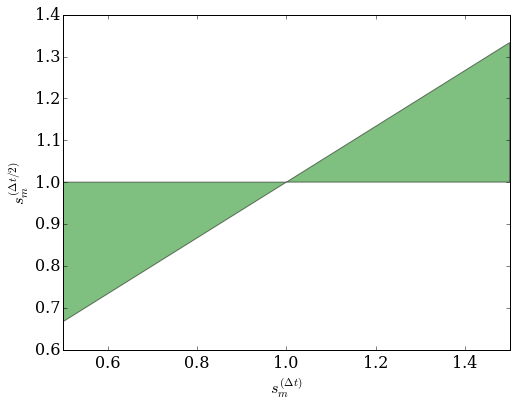

In [23]:
s_m_values = numpy.linspace(0.5, 1.5)
bound = (2.0*s_m_values + 1.0)/3.0
pyplot.figure(figsize=(8,6))
pyplot.fill_between(s_m_values, numpy.ones_like(s_m_values), bound,
                    facecolor='green', alpha=0.5)
#pyplot.ylim(1.0, 2.5)
pyplot.xlim(0.5, 1.5)
pyplot.xlabel(r"$s_m^{(\Delta t)}$")
pyplot.ylabel(r"$s_m^{(\Delta t / 2)}$");

## Summary

If we want the algorithm to behave in the way expected of Euler's method, then measuring a single convergence rate is useful but not sufficient. Instead we must measure the convergence rate twice, once with base timestep $\dt$ and once with base timestep $\dt/2$. The difference between the measured slope $\sm{\dt}$ and the expected slope $s_e=1$ must go down by at least $2/3$ when the timestep is reduced to $\dt/2$.